In [1]:

from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from PIL import Image, ImageFile
from PIL import ImageDraw
import datasets
from datasets import load_dataset


Found 15000 files
First 5 files: ['3430_i2.png', '2107_i2.png', '0969_h.png', '2656_i2.png', '3361_i2.png']
Found 5000 'h' images in ../data/terrain_reconstruction/_dataset
Found 5000 't' images in ../data/terrain_reconstruction/_dataset
Found 5000 'i' images in ../data/terrain_reconstruction/_dataset


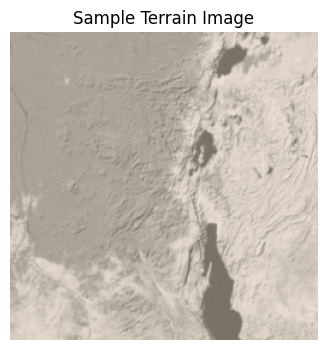

In [2]:
# Dataset path
dataset_path = '../data/terrain_reconstruction/_dataset'

all_files = os.listdir(dataset_path)
print(f"Found {len(all_files)} files")
print("First 5 files:", all_files[:5])

# Define dataset class
class TerrainDataset(Dataset):
    def __init__(self, data_dir, image_type, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(data_dir, f) for f in os.listdir(data_dir) if image_type in f
        ]
        print(f"Found {len(self.image_paths)} '{image_type}' images in {data_dir}")
        # self.labels = [
        #     int(os.path.basename(f).split('_')[0]) for f in self.image_paths
        # ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        # label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image

# Define transform
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Use the correct variable in dataset
heightmap_dataset = TerrainDataset(dataset_path, 'h', transform=transform_pipeline)
terrain_dataset = TerrainDataset(dataset_path, 't', transform=transform_pipeline)
segmentation_dataset = TerrainDataset(dataset_path, 'i', transform=transform_pipeline)


# Function to show a normalized image
def show_tensor_image(tensor_img, title=""):
    # De-normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = tensor_img * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    
    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show sample image from terrain dataset
image = next(iter(terrain_dataset))[0]
show_tensor_image(image, title="Sample Terrain Image")

In [5]:
from unet import UNet
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

#initialize dataloaders
numworkers=0
heightmap_loader = DataLoader(heightmap_dataset, batch_size=32, shuffle=True, num_workers=numworkers)
terrain_loader = DataLoader(terrain_dataset, batch_size=32, shuffle=True, num_workers=numworkers)
segmentation_loader = DataLoader(segmentation_dataset, batch_size=32, shuffle=True, num_workers=numworkers)
# Initialize UNet model
unet_model = UNet(in_channels=3, out_channels=3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)


In [6]:
num_epochs = 10
for epoch in range(num_epochs):
    unet_model.train()
    running_loss = 0.0
    
    for i, (images) in enumerate(heightmap_loader):
        images = images.to(device)
        
        # Forward pass
        outputs = unet_model(images)
        loss = criterion(outputs, images)
        running_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(heightmap_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [10/157], Loss: -73348055040.0000
Epoch [1/10], Step [20/157], Loss: -7737764701961977856.0000
Epoch [1/10], Step [30/157], Loss: -173958218949032425816064.0000
Epoch [1/10], Step [40/157], Loss: -772792836186834028462080.0000
Epoch [1/10], Step [50/157], Loss: -1287898925067565130579968.0000
Epoch [1/10], Step [60/157], Loss: -1994231096718179199614976.0000
Epoch [1/10], Step [70/157], Loss: -2717076563079277137887232.0000
Epoch [1/10], Step [80/157], Loss: -4008950185033974373416960.0000
Epoch [1/10], Step [90/157], Loss: -3519984069254412199002112.0000
Epoch [1/10], Step [100/157], Loss: -4929097990782203551809536.0000
Epoch [1/10], Step [110/157], Loss: -5359642691619575272833024.0000
Epoch [1/10], Step [120/157], Loss: -5984692744273902023213056.0000
Epoch [1/10], Step [130/157], Loss: -6549169453997689640321024.0000
Epoch [1/10], Step [140/157], Loss: -7272086401492073203105792.0000
Epoch [1/10], Step [150/157], Loss: -6850658427452380124545024.0000
Epoch [2/10

KeyboardInterrupt: 